In [7]:
## Trim down imports to only neccesary 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from transformers import AutoFeatureExtractor, ViTForImageClassification, ViTModel
import torch
from torchvision.transforms import v2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('default')
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.utils.data import Subset
from collections import namedtuple
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec

import datasets_1 as datasets

import os
import datetime
import re




import simple_datasets as sd
from sklearn.manifold import TSNE



In [2]:
## Pretrained model

class CustomViTEmbeddingModel(torch.nn.Module):
    def __init__(self, original_model):
        super(CustomViTEmbeddingModel, self).__init__()
        
        # Extract the necessary layers from the original model
        self.embeddings = original_model.vit.embeddings  #.patch_embeddings
        self.encoder_layer_0 = original_model.vit.encoder.layer[0]
        self.encoder_layer_1 = original_model.vit.encoder.layer[1]
        
        # Assume a square grid of patches to reshape the sequence of patches back into a 2D grid
            ## image: 224x224 ; patch size: 16x16 --> 14x14 
        self.num_patches_side = 14

    def forward(self, x):
        # Apply the embeddings layer
        x = self.embeddings(x)
        
        # Pass the result through the first and second encoder layers
        x = self.encoder_layer_0(x)[0]  # [0] to get the hidden states
        x = self.encoder_layer_1(x)[0]  # [0] to get the hidden states
        
        # x is now the sequence of embeddings for the patches
            # The output x will be a sequence of embeddings, one for each patch of the input images.
            # If you're looking for a single vector representation per image, typically the class token embedding (the first token) is used. 
            # If the model doesn't use a class token, you might need to apply a different pooling strategy over the patch embeddings.
        
        ## Updating to reshape
        
        # Before reshaping, x is in shape [batch_size, num_patches+1, embedding_dim]
        # We discard the first token which is used for classification in the original ViT model
        x = x[:, 1:, :]  # Now in shape [batch_size, num_patches, embedding_dim]
        
        # Reshape to [batch_size, num_patches_side, num_patches_side, embedding_dim]
        x = x.reshape(-1, self.num_patches_side, self.num_patches_side, x.size(-1))

        # Permute to get [batch_size, embedding_dim, num_patches_side, num_patches_side]
        # This is a pseudo-spatial 2D grid, where embedding_dim becomes the channel dimension
        x = x.permute(0, 3, 1, 2)
        
        return x



In [10]:
## Adding in CNN component

## CNN for regression
class RegressionCNN(nn.Module):
    ## Maybe try messing w/ kernel_size, padding and stride?
    def __init__(self, embedding_dim):
        super(RegressionCNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=embedding_dim, out_channels=256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.sig1 = nn.Sigmoid()

        # Second convolutional layer
            ## Same amount? Dropout should help it to learn other things
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.sig2 = nn.Sigmoid()
        
        # Third convolutional layer -- new
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.sig3 = nn.Sigmoid()
        
        # Implementing dropout
        self.dropout = nn.Dropout(p=0.1)

        # Adaptive pooling layer to pool down to 1x1
        self.adapt_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Final fully connected layer for regressin
        self.fc = nn.Linear(in_features=64, out_features=1)

    def forward(self, x, return_embedding = False):
        batch_size = x.size(0)  # Get the batch size

        # Apply convolutions and optionally batch norm
        x = self.conv1(x)
        if batch_size > 1:  # Apply batch norm only for batch sizes > 1
            x = self.bn1(x)
        x = self.sig1(x)
        
        x = self.conv2(x)
        if batch_size > 1:  # Apply batch norm only for batch sizes > 1
            x = self.bn2(x)
        x = self.sig2(x)
        
        x = self.conv3(x)
        if batch_size > 1:  # Apply batch norm only for batch sizes > 1
            x = self.bn3(x)
        x = self.sig3(x)

        if return_embedding:
            x = torch.flatten(x, start_dim=1)
            return x

        x = self.dropout(x)
        x = self.adapt_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)

        return x
    
def calculate_rmse_and_r2(loader, model):
    model.eval()
    targets, predictions = [], []
    with torch.no_grad():
        for batch in loader:
            _, images, labels, _, _ = batch
            embeddings = custom_model(images)  # Get embeddings from the ViT
            preds = cnn_model(embeddings).squeeze(-1)  # Pass embeddings to the CNN --> squeeze after
            predictions.extend(preds.tolist())
            targets.extend(labels.tolist())

    
    # Convert to tensors
    targets = torch.tensor(targets)
    predictions = torch.tensor(predictions)
    
    # Calculate RMSE on scaled targets
    rmse_value = torch.sqrt(nn.functional.mse_loss(predictions, targets))

    # Calculate R^2 on scaled targets
    r2_value = r2_score(targets, predictions)

    return rmse_value.item(), r2_value

In [4]:
# Mapping dictionary
label_mapping = {'LVID': 0, 'SVID': 1}

# Function to convert labels to tensor
def labels_to_tensor(labels):
    # Map the labels to integers using label_mapping
    mapped_labels = [label_mapping[label] for label in labels]
    # Convert the list of integers to a tensor
    label_tensor = torch.tensor(mapped_labels, dtype=torch.long)
    return label_tensor

# Function to convert tensor back to labels
def tensor_to_labels(tensor):
    # Inverse mapping
    inverse_label_mapping = {v: k for k, v in label_mapping.items()}
    # Convert the tensor of indices to labels
    labels = [inverse_label_mapping[int(index)] for index in tensor]
    return labels


In [5]:
def load_loaders(train, test, target, sediment_width = 1):
    # Load data from CSV
    if train.upper() != "BOTH":
        train_path = f"/Users/willhoff/Desktop/research_23_24/paleoclimate/will_sandbox/chunk_data/{train.upper()}/{sediment_width}cm/data/{target.upper()}_dataset.csv"
        train_loader = sd.create_loader(train_path,
                        set = "Train")
    elif train.upper() == "BOTH":
        train_path = f"/Users/willhoff/Desktop/research_23_24/paleoclimate/will_sandbox/chunk_data/LVID/{sediment_width}cm/data/{target.upper()}_dataset.csv"
        second_path = f"/Users/willhoff/Desktop/research_23_24/paleoclimate/will_sandbox/chunk_data/SVID/{sediment_width}cm/data/{target.upper()}_dataset.csv"
        train_loader = sd.create_loader(train_path,
                                        set = "Train",
                                        second_csv = second_path)
    if test.upper() != "BOTH":
        test_path = f"/Users/willhoff/Desktop/research_23_24/paleoclimate/will_sandbox/chunk_data/{test.upper()}/{sediment_width}cm/data/{target.upper()}_dataset.csv"
        test_loader = sd.create_loader(test_path,
                        set = "Test")
    elif test.upper() == "BOTH":
        test_path = f"/Users/willhoff/Desktop/research_23_24/paleoclimate/will_sandbox/chunk_data/LVID/{sediment_width}cm/data/{target.upper()}_dataset.csv"
        second_path = f"/Users/willhoff/Desktop/research_23_24/paleoclimate/will_sandbox/chunk_data/SVID/{sediment_width}cm/data/{target.upper()}_dataset.csv"
        test_loader = sd.create_loader(test_path,
                                        set = "Test",
                                        second_csv = second_path)
        
        return train_loader, test_loader

In [23]:
print(load_loaders("both", "LVID", target, sediment_width = 1))

None


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 1/100
Train Loss: 0.0127 Val Loss: 0.0018
Train RMSE: 0.0363, Train R2: -0.1862
Val RMSE: 0.0434, Val R2: -0.2417


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 2/100
Train Loss: 0.0017 Val Loss: 0.0020
Train RMSE: 0.0479, Train R2: -1.0624
Val RMSE: 0.0444, Val R2: -0.3016


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 3/100
Train Loss: 0.0014 Val Loss: 0.0013
Train RMSE: 0.0306, Train R2: 0.1547
Val RMSE: 0.0372, Val R2: 0.0896


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 4/100
Train Loss: 0.0011 Val Loss: 0.0014
Train RMSE: 0.0370, Train R2: -0.2348
Val RMSE: 0.0375, Val R2: 0.0739


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 5/100
Train Loss: 0.0009 Val Loss: 0.0013
Train RMSE: 0.0284, Train R2: 0.2728
Val RMSE: 0.0360, Val R2: 0.1460


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 6/100
Train Loss: 0.0011 Val Loss: 0.0017
Train RMSE: 0.0332, Train R2: 0.0075
Val RMSE: 0.0417, Val R2: -0.1480


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 7/100
Train Loss: 0.0009 Val Loss: 0.0025
Train RMSE: 0.0404, Train R2: -0.4664
Val RMSE: 0.0500, Val R2: -0.6487


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 8/100
Train Loss: 0.0009 Val Loss: 0.0029
Train RMSE: 0.0491, Train R2: -1.1711
Val RMSE: 0.0529, Val R2: -0.8452


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 9/100
Train Loss: 0.0008 Val Loss: 0.0027
Train RMSE: 0.0441, Train R2: -0.7495
Val RMSE: 0.0524, Val R2: -0.8076


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 10/100
Train Loss: 0.0009 Val Loss: 0.0031
Train RMSE: 0.0454, Train R2: -0.8595
Val RMSE: 0.0538, Val R2: -0.9090


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 11/100
Train Loss: 0.0009 Val Loss: 0.0030
Train RMSE: 0.0493, Train R2: -1.1915
Val RMSE: 0.0564, Val R2: -1.0986


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 12/100
Train Loss: 0.0009 Val Loss: 0.0060
Train RMSE: 0.0678, Train R2: -3.1428
Val RMSE: 0.0754, Val R2: -2.7428


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 13/100
Train Loss: 0.0011 Val Loss: 0.0043
Train RMSE: 0.0639, Train R2: -2.6809
Val RMSE: 0.0664, Val R2: -1.9074


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 14/100
Train Loss: 0.0009 Val Loss: 0.0017
Train RMSE: 0.0322, Train R2: 0.0687
Val RMSE: 0.0418, Val R2: -0.1520


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 15/100
Train Loss: 0.0009 Val Loss: 0.0015
Train RMSE: 0.0323, Train R2: 0.0578
Val RMSE: 0.0384, Val R2: 0.0257


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 16/100
Train Loss: 0.0007 Val Loss: 0.0014
Train RMSE: 0.0272, Train R2: 0.3341
Val RMSE: 0.0379, Val R2: 0.0508


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 17/100
Train Loss: 0.0007 Val Loss: 0.0014
Train RMSE: 0.0244, Train R2: 0.4647
Val RMSE: 0.0364, Val R2: 0.1264


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 18/100
Train Loss: 0.0010 Val Loss: 0.0023
Train RMSE: 0.0376, Train R2: -0.2756
Val RMSE: 0.0483, Val R2: -0.5359


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 19/100
Train Loss: 0.0010 Val Loss: 0.0085
Train RMSE: 0.0874, Train R2: -5.8716
Val RMSE: 0.0939, Val R2: -4.8107


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 20/100
Train Loss: 0.0008 Val Loss: 0.0036
Train RMSE: 0.0499, Train R2: -1.2425
Val RMSE: 0.0587, Val R2: -1.2677


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 21/100
Train Loss: 0.0008 Val Loss: 0.0016
Train RMSE: 0.0344, Train R2: -0.0677
Val RMSE: 0.0395, Val R2: -0.0279


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 22/100
Train Loss: 0.0006 Val Loss: 0.0009
Train RMSE: 0.0174, Train R2: 0.7260
Val RMSE: 0.0313, Val R2: 0.3537


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 23/100
Train Loss: 0.0006 Val Loss: 0.0013
Train RMSE: 0.0300, Train R2: 0.1885
Val RMSE: 0.0363, Val R2: 0.1327


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 24/100
Train Loss: 0.0006 Val Loss: 0.0028
Train RMSE: 0.0439, Train R2: -0.7329
Val RMSE: 0.0543, Val R2: -0.9433


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 25/100
Train Loss: 0.0005 Val Loss: 0.0015
Train RMSE: 0.0215, Train R2: 0.5829
Val RMSE: 0.0381, Val R2: 0.0409


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 26/100
Train Loss: 0.0006 Val Loss: 0.0016
Train RMSE: 0.0250, Train R2: 0.4383
Val RMSE: 0.0411, Val R2: -0.1146


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 27/100
Train Loss: 0.0007 Val Loss: 0.0012
Train RMSE: 0.0156, Train R2: 0.7815
Val RMSE: 0.0336, Val R2: 0.2571


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 28/100
Train Loss: 0.0006 Val Loss: 0.0040
Train RMSE: 0.0546, Train R2: -1.6855
Val RMSE: 0.0647, Val R2: -1.7571


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 29/100
Train Loss: 0.0007 Val Loss: 0.0011
Train RMSE: 0.0142, Train R2: 0.8186
Val RMSE: 0.0327, Val R2: 0.2933


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 30/100
Train Loss: 0.0004 Val Loss: 0.0011
Train RMSE: 0.0145, Train R2: 0.8105
Val RMSE: 0.0346, Val R2: 0.2130


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 31/100
Train Loss: 0.0005 Val Loss: 0.0015
Train RMSE: 0.0221, Train R2: 0.5592
Val RMSE: 0.0392, Val R2: -0.0153


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 32/100
Train Loss: 0.0004 Val Loss: 0.0018
Train RMSE: 0.0318, Train R2: 0.0879
Val RMSE: 0.0434, Val R2: -0.2414


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 33/100
Train Loss: 0.0005 Val Loss: 0.0010
Train RMSE: 0.0103, Train R2: 0.9041
Val RMSE: 0.0326, Val R2: 0.3009


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 34/100
Train Loss: 0.0006 Val Loss: 0.0040
Train RMSE: 0.0551, Train R2: -1.7362
Val RMSE: 0.0649, Val R2: -1.7780


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 35/100
Train Loss: 0.0007 Val Loss: 0.0060
Train RMSE: 0.0712, Train R2: -3.5625
Val RMSE: 0.0768, Val R2: -2.8862


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 36/100
Train Loss: 0.0007 Val Loss: 0.0009
Train RMSE: 0.0177, Train R2: 0.7187
Val RMSE: 0.0311, Val R2: 0.3619


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 37/100
Train Loss: 0.0004 Val Loss: 0.0010
Train RMSE: 0.0121, Train R2: 0.8672
Val RMSE: 0.0314, Val R2: 0.3497


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 38/100
Train Loss: 0.0010 Val Loss: 0.0024
Train RMSE: 0.0435, Train R2: -0.7076
Val RMSE: 0.0489, Val R2: -0.5740


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 39/100
Train Loss: 0.0014 Val Loss: 0.0034
Train RMSE: 0.0482, Train R2: -1.0897
Val RMSE: 0.0597, Val R2: -1.3482


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 40/100
Train Loss: 0.0006 Val Loss: 0.0046
Train RMSE: 0.0598, Train R2: -2.2227
Val RMSE: 0.0672, Val R2: -1.9767


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 41/100
Train Loss: 0.0003 Val Loss: 0.0040
Train RMSE: 0.0544, Train R2: -1.6636
Val RMSE: 0.0648, Val R2: -1.7705


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 42/100
Train Loss: 0.0004 Val Loss: 0.0028
Train RMSE: 0.0478, Train R2: -1.0602
Val RMSE: 0.0518, Val R2: -0.7713


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 43/100
Train Loss: 0.0006 Val Loss: 0.0008
Train RMSE: 0.0140, Train R2: 0.8229
Val RMSE: 0.0293, Val R2: 0.4337


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 44/100
Train Loss: 0.0005 Val Loss: 0.0016
Train RMSE: 0.0296, Train R2: 0.2092
Val RMSE: 0.0418, Val R2: -0.1521


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 45/100
Train Loss: 0.0005 Val Loss: 0.0025
Train RMSE: 0.0421, Train R2: -0.5946
Val RMSE: 0.0493, Val R2: -0.6052


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 46/100
Train Loss: 0.0002 Val Loss: 0.0017
Train RMSE: 0.0268, Train R2: 0.3530
Val RMSE: 0.0411, Val R2: -0.1121


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 47/100
Train Loss: 0.0004 Val Loss: 0.0038
Train RMSE: 0.0511, Train R2: -1.3475
Val RMSE: 0.0630, Val R2: -1.6140


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 48/100
Train Loss: 0.0006 Val Loss: 0.0015
Train RMSE: 0.0190, Train R2: 0.6751
Val RMSE: 0.0371, Val R2: 0.0930


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 49/100
Train Loss: 0.0003 Val Loss: 0.0029
Train RMSE: 0.0448, Train R2: -0.8052
Val RMSE: 0.0553, Val R2: -1.0192


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 50/100
Train Loss: 0.0003 Val Loss: 0.0013
Train RMSE: 0.0240, Train R2: 0.4829
Val RMSE: 0.0357, Val R2: 0.1602


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 51/100
Train Loss: 0.0002 Val Loss: 0.0011
Train RMSE: 0.0145, Train R2: 0.8111
Val RMSE: 0.0328, Val R2: 0.2915


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 52/100
Train Loss: 0.0003 Val Loss: 0.0012
Train RMSE: 0.0192, Train R2: 0.6695
Val RMSE: 0.0363, Val R2: 0.1294


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 53/100
Train Loss: 0.0002 Val Loss: 0.0025
Train RMSE: 0.0378, Train R2: -0.2852
Val RMSE: 0.0483, Val R2: -0.5371


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 54/100
Train Loss: 0.0004 Val Loss: 0.0018
Train RMSE: 0.0308, Train R2: 0.1431
Val RMSE: 0.0420, Val R2: -0.1633


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 55/100
Train Loss: 0.0002 Val Loss: 0.0020
Train RMSE: 0.0350, Train R2: -0.1055
Val RMSE: 0.0466, Val R2: -0.4291


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 56/100
Train Loss: 0.0003 Val Loss: 0.0015
Train RMSE: 0.0174, Train R2: 0.7265
Val RMSE: 0.0378, Val R2: 0.0581


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 57/100
Train Loss: 0.0002 Val Loss: 0.0009
Train RMSE: 0.0057, Train R2: 0.9704
Val RMSE: 0.0301, Val R2: 0.4029


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 58/100
Train Loss: 0.0005 Val Loss: 0.0015
Train RMSE: 0.0291, Train R2: 0.2393
Val RMSE: 0.0394, Val R2: -0.0251


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 59/100
Train Loss: 0.0004 Val Loss: 0.0022
Train RMSE: 0.0333, Train R2: -0.0013
Val RMSE: 0.0460, Val R2: -0.3929


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 60/100
Train Loss: 0.0002 Val Loss: 0.0017
Train RMSE: 0.0328, Train R2: 0.0321
Val RMSE: 0.0428, Val R2: -0.2072


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 61/100
Train Loss: 0.0002 Val Loss: 0.0012
Train RMSE: 0.0193, Train R2: 0.6657
Val RMSE: 0.0353, Val R2: 0.1803


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 62/100
Train Loss: 0.0002 Val Loss: 0.0010
Train RMSE: 0.0066, Train R2: 0.9613
Val RMSE: 0.0312, Val R2: 0.3602


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 63/100
Train Loss: 0.0004 Val Loss: 0.0014
Train RMSE: 0.0184, Train R2: 0.6956
Val RMSE: 0.0368, Val R2: 0.1061


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 64/100
Train Loss: 0.0004 Val Loss: 0.0008
Train RMSE: 0.0070, Train R2: 0.9565
Val RMSE: 0.0294, Val R2: 0.4315


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 65/100
Train Loss: 0.0003 Val Loss: 0.0046
Train RMSE: 0.0587, Train R2: -2.1002
Val RMSE: 0.0661, Val R2: -1.8844


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 66/100
Train Loss: 0.0004 Val Loss: 0.0013
Train RMSE: 0.0250, Train R2: 0.4377
Val RMSE: 0.0374, Val R2: 0.0795


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 67/100
Train Loss: 0.0003 Val Loss: 0.0013
Train RMSE: 0.0210, Train R2: 0.6031
Val RMSE: 0.0351, Val R2: 0.1897


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 68/100
Train Loss: 0.0003 Val Loss: 0.0008
Train RMSE: 0.0059, Train R2: 0.9688
Val RMSE: 0.0289, Val R2: 0.4502


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 69/100
Train Loss: 0.0004 Val Loss: 0.0009
Train RMSE: 0.0091, Train R2: 0.9249
Val RMSE: 0.0311, Val R2: 0.3613


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 70/100
Train Loss: 0.0004 Val Loss: 0.0016
Train RMSE: 0.0287, Train R2: 0.2605
Val RMSE: 0.0393, Val R2: -0.0193


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 71/100
Train Loss: 0.0002 Val Loss: 0.0009
Train RMSE: 0.0062, Train R2: 0.9651
Val RMSE: 0.0300, Val R2: 0.4067


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 72/100
Train Loss: 0.0003 Val Loss: 0.0012
Train RMSE: 0.0249, Train R2: 0.4405
Val RMSE: 0.0352, Val R2: 0.1822


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 73/100
Train Loss: 0.0002 Val Loss: 0.0037
Train RMSE: 0.0542, Train R2: -1.6456
Val RMSE: 0.0622, Val R2: -1.5469


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 74/100
Train Loss: 0.0002 Val Loss: 0.0012
Train RMSE: 0.0171, Train R2: 0.7354
Val RMSE: 0.0348, Val R2: 0.2038


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 75/100
Train Loss: 0.0002 Val Loss: 0.0011
Train RMSE: 0.0149, Train R2: 0.7999
Val RMSE: 0.0324, Val R2: 0.3099


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 76/100
Train Loss: 0.0002 Val Loss: 0.0008
Train RMSE: 0.0049, Train R2: 0.9783
Val RMSE: 0.0293, Val R2: 0.4356


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 77/100
Train Loss: 0.0002 Val Loss: 0.0015
Train RMSE: 0.0209, Train R2: 0.6064
Val RMSE: 0.0374, Val R2: 0.0802


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 78/100
Train Loss: 0.0002 Val Loss: 0.0034
Train RMSE: 0.0523, Train R2: -1.4647
Val RMSE: 0.0599, Val R2: -1.3619


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 79/100
Train Loss: 0.0003 Val Loss: 0.0074
Train RMSE: 0.0792, Train R2: -4.6510
Val RMSE: 0.0849, Val R2: -3.7495


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 80/100
Train Loss: 0.0003 Val Loss: 0.0047
Train RMSE: 0.0638, Train R2: -2.6631
Val RMSE: 0.0702, Val R2: -2.2494


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 81/100
Train Loss: 0.0002 Val Loss: 0.0051
Train RMSE: 0.0642, Train R2: -2.7140
Val RMSE: 0.0702, Val R2: -2.2495


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 82/100
Train Loss: 0.0004 Val Loss: 0.0014
Train RMSE: 0.0260, Train R2: 0.3929
Val RMSE: 0.0366, Val R2: 0.1168


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 83/100
Train Loss: 0.0003 Val Loss: 0.0015
Train RMSE: 0.0271, Train R2: 0.3405
Val RMSE: 0.0395, Val R2: -0.0281


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 84/100
Train Loss: 0.0003 Val Loss: 0.0025
Train RMSE: 0.0403, Train R2: -0.4651
Val RMSE: 0.0514, Val R2: -0.7423


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 85/100
Train Loss: 0.0004 Val Loss: 0.0025
Train RMSE: 0.0402, Train R2: -0.4553
Val RMSE: 0.0490, Val R2: -0.5853


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 86/100
Train Loss: 0.0002 Val Loss: 0.0026
Train RMSE: 0.0467, Train R2: -0.9647
Val RMSE: 0.0527, Val R2: -0.8332


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 87/100
Train Loss: 0.0002 Val Loss: 0.0036
Train RMSE: 0.0525, Train R2: -1.4790
Val RMSE: 0.0613, Val R2: -1.4771


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 88/100
Train Loss: 0.0002 Val Loss: 0.0010
Train RMSE: 0.0101, Train R2: 0.9085
Val RMSE: 0.0320, Val R2: 0.3243


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 89/100
Train Loss: 0.0003 Val Loss: 0.0068
Train RMSE: 0.0754, Train R2: -4.1248
Val RMSE: 0.0818, Val R2: -3.4060


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 90/100
Train Loss: 0.0002 Val Loss: 0.0058
Train RMSE: 0.0698, Train R2: -3.3891
Val RMSE: 0.0753, Val R2: -2.7332


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 91/100
Train Loss: 0.0002 Val Loss: 0.0023
Train RMSE: 0.0417, Train R2: -0.5652
Val RMSE: 0.0495, Val R2: -0.6162


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 92/100
Train Loss: 0.0002 Val Loss: 0.0010
Train RMSE: 0.0095, Train R2: 0.9187
Val RMSE: 0.0321, Val R2: 0.3221


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 93/100
Train Loss: 0.0002 Val Loss: 0.0009
Train RMSE: 0.0062, Train R2: 0.9657
Val RMSE: 0.0306, Val R2: 0.3816


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 94/100
Train Loss: 0.0002 Val Loss: 0.0009
Train RMSE: 0.0089, Train R2: 0.9294
Val RMSE: 0.0300, Val R2: 0.4063


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 95/100
Train Loss: 0.0001 Val Loss: 0.0017
Train RMSE: 0.0285, Train R2: 0.2666
Val RMSE: 0.0403, Val R2: -0.0724


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 96/100
Train Loss: 0.0001 Val Loss: 0.0033
Train RMSE: 0.0509, Train R2: -1.3328
Val RMSE: 0.0567, Val R2: -1.1187


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 97/100
Train Loss: 0.0002 Val Loss: 0.0014
Train RMSE: 0.0276, Train R2: 0.3122
Val RMSE: 0.0371, Val R2: 0.0939


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 98/100
Train Loss: 0.0001 Val Loss: 0.0016
Train RMSE: 0.0282, Train R2: 0.2825
Val RMSE: 0.0415, Val R2: -0.1346


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 99/100
Train Loss: 0.0001 Val Loss: 0.0009
Train RMSE: 0.0063, Train R2: 0.9640
Val RMSE: 0.0298, Val R2: 0.4141


RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

RegressionCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 100/100
Train Loss: 0.0003 Val Loss: 0.0013
Train RMSE: 0.0232, Train R2: 0.5147
Val RMSE: 0.0363, Val R2: 0.1328


<Figure size 1200x500 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Loss Over Epochs')

<Axes: >

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'RMSE')

Text(0.5, 1.0, 'RMSE Over Epochs (Train: SVID Test: Both)')

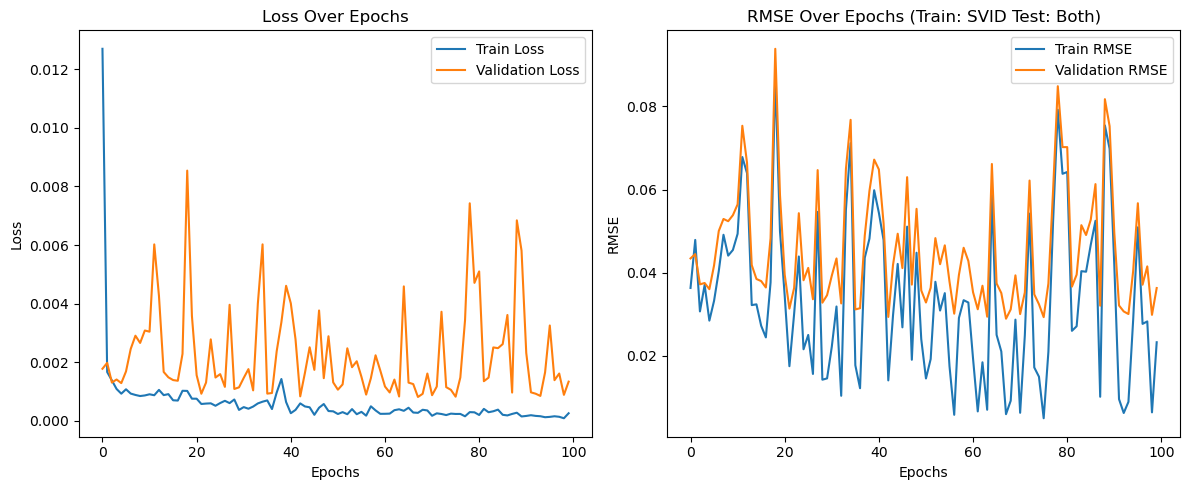

In [28]:
############################################ ############################################ ############################################ 
############################################ ############################################ ############################################ 
###############################################       TRAINING          ############################################ 
############################################ ############################################ ############################################ 
############################################ ############################################ ############################################ 


# Training loop
num_epochs = 100
## Started w 0.001, went up to 0.01
lr = 0.001
width = 1

# Instantiate the model
cnn_model = RegressionCNN(embedding_dim=192)

# Load the pre-trained ViT model
pretrained_vit = ViTForImageClassification.from_pretrained('facebook/deit-tiny-patch16-224')

## Freeze params
for param in pretrained_vit.parameters():
    param.requires_grad = False

# Create model w first three layers and create embedding
custom_model = CustomViTEmbeddingModel(pretrained_vit)

# Define a Loss Function and Optimizer for classification
loss_function = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=lr)


# Define the combinations
combinations = [
    ("lvid", "both"),
    ("svid", "both"),
    ("both", "both")
]
targets = ['MBT', '%TOC']

train = "BOTH"
test = "BOTH"
target = 'MBT'

train_loader, test_loader = load_loaders(train, test, target, sediment_width = 1)
train_losses = []
val_losses = []
train_rmses = []
val_rmses = []
for epoch in range(num_epochs):
    cnn_model.train()
    train_loss = 0
    
    correct = 0
    total = 0
    for batch in train_loader:
        optimizer.zero_grad()
        _, images, labels, batch_depths, batch_source = batch
        embeddings = custom_model(images)  # Get embeddings from the ViT
        predictions = cnn_model(embeddings)  # Pass embeddings to the CNN
        # Squeeze the predictions to match the label's shape
        predictions = predictions.squeeze(-1)  # This removes the last dimension (i.e., from [batch_size, 1] to [batch_size])
        loss = loss_function(predictions.squeeze(), labels) 
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation step
    cnn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            _, images, labels, batch_depths, batch_source = batch
            embeddings = custom_model(images)
            outputs = cnn_model(embeddings)
            # Squeeze the predictions to match the label's shape
            outputs = outputs.squeeze(-1)  # This removes the last dimension (i.e., from [batch_size, 1] to [batch_size])
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
    
    # Calculate RMSE and R-squared for training and validation sets
    train_rmse, train_r2 = calculate_rmse_and_r2(train_loader, cnn_model)
    val_rmse, val_r2 = calculate_rmse_and_r2(test_loader, cnn_model)
    train_rmses.append(train_rmse)
    val_rmses.append(val_rmse)
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(test_loader))
    
    # Print out the metrics
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss / len(train_loader):.4f} Val Loss: {val_loss / len(test_loader):.4f}')
    print(f'Train RMSE: {train_rmse:.4f}, Train R2: {train_r2:.4f}')
    print(f'Val RMSE: {val_rmse:.4f}, Val R2: {val_r2:.4f}')

# Plotting
plt.figure(figsize=(12, 5))

# Left plot for loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Right plot for RMSE
plt.subplot(1, 2, 2)
plt.plot(train_rmses, label='Train RMSE')
plt.plot(val_rmses, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs (Train: SVID Test: Both)')
plt.legend()

plt.tight_layout()

timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H-%M-%S")
save_dir = f't-SNE/{width}cm'

# Saving the plot
# Ensure the target directory exists
os.makedirs(save_dir, exist_ok=True)
filename = f'%TOC_plot_SVID_train_both_test_{timestamp}.png'

plt.savefig(os.path.join(save_dir, filename))

plt.show()

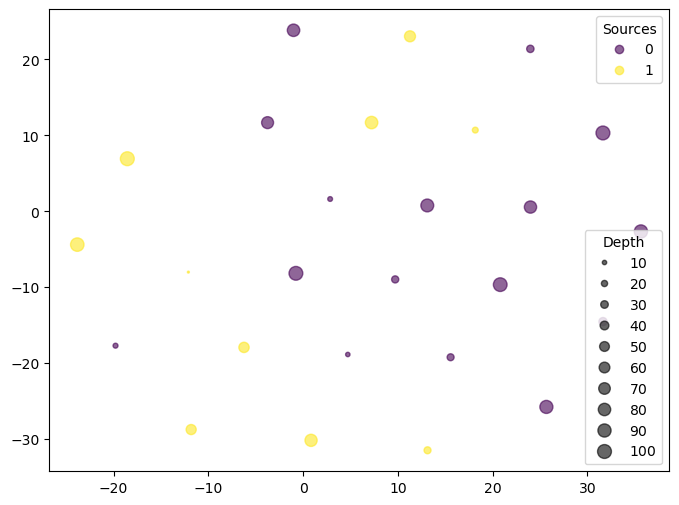

In [29]:
### T-SNE Demo starts here

def get_embeddings(model, test_loader):
    model.eval()
    all_embeddings = []
    all_depths = []
    all_sources = []
    with torch.no_grad():
        for _,images, _, depths, sources in test_loader:
            vit_embeddings = custom_model(images)  # Get embeddings from the ViT
            embeddings = model(vit_embeddings, return_embedding=True)
            embeddings = embeddings.reshape(embeddings.size(0), -1)
            all_embeddings.append(embeddings)
            all_depths.extend(depths)
            all_sources.extend(sources)
    
     # Concatenate all embeddings into a single 2D array
    all_embeddings_np = np.concatenate(all_embeddings, axis=0)
    
    # Determine the number of samples
    n_samples = all_embeddings_np.shape[0]

    # Ensure perplexity is less than the number of samples
    perplexity_value = min(30, n_samples - 1)  # Using 30 as default, adjust as needed
    
    # Apply t-SNE transformation with adjusted perplexity
    tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
    embeddings_2d = tsne.fit_transform(all_embeddings_np)
    
    return embeddings_2d, all_depths, all_sources

def plot_tsne(embeddings_2d, depths, sources):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Calculate max and min depths for each lake
    max_depths = {}
    min_depths = {}
    for source in set(sources):
        source_mask = [s == source for s in sources]
        max_depths[source] = max([d for d, m in zip(depths, source_mask) if m])
        min_depths[source] = min([d for d, m in zip(depths, source_mask) if m])
    
    # Normalize depths differently based on source
    normalized_depths = [
        100 * (depth - min_depths[source]) / (max_depths[source] - min_depths[source])
        for depth, source in zip(depths, sources)
    ]
    
    # Convert sources to numeric values for coloring
    unique_sources = list(set(sources))
    source_colors = {source: i for i, source in enumerate(unique_sources)}
    colors = [source_colors[source] for source in sources]

    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, s=normalized_depths, cmap='viridis', alpha=0.6)
    
    # Create a legend for sources
    legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Sources")
    ax.add_artist(legend1)
    
    # Create a legend for sizes (depths)
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
    legend2 = ax.legend(handles, labels, loc="lower right", title="Depth")
    
    timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H-%M-%S")
    save_dir = 't-SNE/1cm'

    # Saving the plot
    # Ensure the target directory exists
    os.makedirs(save_dir, exist_ok=True)
    filename = f't-SNE_{timestamp}.png'

    plt.savefig(os.path.join(save_dir, filename))
    plt.show()

# Get the embeddings, depths, and sources
embeddings_2d, depths, sources = get_embeddings(cnn_model, test_loader)

# Plot the t-SNE visualization
plot_tsne(embeddings_2d, depths, sources)
